# Conditional Embedding

In this notebook, I will reproduce four conditional  embedding  applications: image colorization, inpainting, super resolution, and style transfer.

This embeddings are based on the work [Improved StyleGAN Embedding: Where are the Good Latents?
](https://arxiv.org/abs/2012.09036)

Let $I$ be an input "condition" image, and $G$ be a StyleGAN generator. Conditional embedding aims to locate an optimal laten code $w^{+\ast}$ in $W^+$ space so that th embedded image $G(w^{+\ast})$
1. faithfully captures the "condition" of $I$.
2. is a realistic face image.

Accordingly, authors define a conditiona embedding as:

$$
\mathbf{w}^{+*}=\arg \min _{\mathbf{w}^{+}} L\left(I, f\left(G\left(\mathbf{w}^{+}\right)\right)\right)+\lambda \cdot R\left(\mathbf{w}^{+}\right)
$$

where $f$ is a "condition" function that modifies an image to satisfy a pre-defined condition (e.g. grayscale), $L$ is a loss function measuring the similarity between two images (e.g. pixel-wise L2 loss, perceptual loss), $\lambda$ is a hyperparameter, and $R$ is the regulizer.

Note: the only difference between orfinary and conditional embedding is the incorporation of $f$.

In [1]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3
!pip install lpips


     |████████████████████████████████| 204kB 7.5MB/s 
     |████████████████████████████████| 112kB 42.6MB/s 
     |████████████████████████████████| 26.9MB 103kB/s 
     |████████████████████████████████| 61kB 5.4MB/s 


In [2]:
!nvidia-smi

Tue May 25 15:53:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/internship/style-gan/

/content/gdrive/MyDrive/internship/style-gan


In [5]:
# import needed packages
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
from torchvision.utils import save_image
import torchvision
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim

import numpy as np 
import cv2

import os
import glob
import time

import model.p_space as p_space
from torchvision import transforms
import dnnlib
import lpips
import warnings
warnings.filterwarnings("ignore")
torch.manual_seed(0)
np.random.seed(0)

In [6]:
# Setting global attributes
RESOLUTION = 1024
#DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ITERATIONS = 1300
SAVE_STEP = 100

# OPTIMIZER
LEARNING_RATE = 0.01
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-8
regularizer_lambda = 0.005

# IMAGE TO EMBED
PATH_DIR = "stuff/data/input/"
PCA_DIR = "stuff/data/pca/"
EXPECTED_RESULTS = "stuff/data/Peihao_result/"
SAVING_DIR = 'stuff/results/conditional_embedding/'
PRETRAINED_MODEL_DIR = "stuff/pretrained_models/"

In [7]:
DEVICE

device(type='cuda', index=0)

In [8]:
# function to load pretrained model
def load_pretrained_model(file_name = "ffhq.pkl", space = 'w+'):
  pretrained_mode = os.path.join(PRETRAINED_MODEL_DIR,file_name)

  with open(pretrained_mode, 'rb') as f:
      G = pickle.load(f)['G_ema'].to(DEVICE)  # torch.nn.Module

      if space == 'w':
        G.mapping.num_ws = 1 # setting to the space w not w+ that was defined by deafault

  return G

In [9]:
G = load_pretrained_model(space='w')

### Loading Data

Here we load some image samples from a folder

In [10]:
#@title Function to load data from a folder
def load_image(path):
    if(path[-3:]=='bmp' or path[-3:]=='jpg' or path[-3:]=='png'):
        return cv2.imread(path)[:,:,::-1]
    else:
        img = (255*plt.imread(path)[:,:,:3]).astype('uint8')

    return img

def load_data(directory, interval = None):

  if interval is None:
    files = sorted(glob.glob(os.path.join(directory + "*.png")))
  else:
    files = sorted(np.array(glob.glob(os.path.join(directory + "*.png")))[interval])

  data = {}
  for idx, file in enumerate(files):
    img_dir = {
        "img": load_image(file),
        "name": os.path.basename(os.path.normpath(file))
    }
    data[idx] = img_dir
  return data

In [11]:
#@title Function to display the data
def display_data(data, ncols=4):

    inches = 4
    num_img = len(data)
    nrows = np.ceil(num_img/ncols).astype(int)
    fig, axs = plt.subplots(nrows,ncols,figsize=(inches * ncols , inches * nrows))

    idx = 0
    for i in range(nrows):
      for j in range(ncols):
        if idx < num_img:
          axs[i,j].imshow(data[idx]['img'])
          axs[i,j].set_title("Image ID: {}".format(idx))
          axs[i,j].axis('off')
          idx += 1


In [12]:
data = load_data(PATH_DIR)
# data = load_data(PATH_DIR, np.r_[0:12])

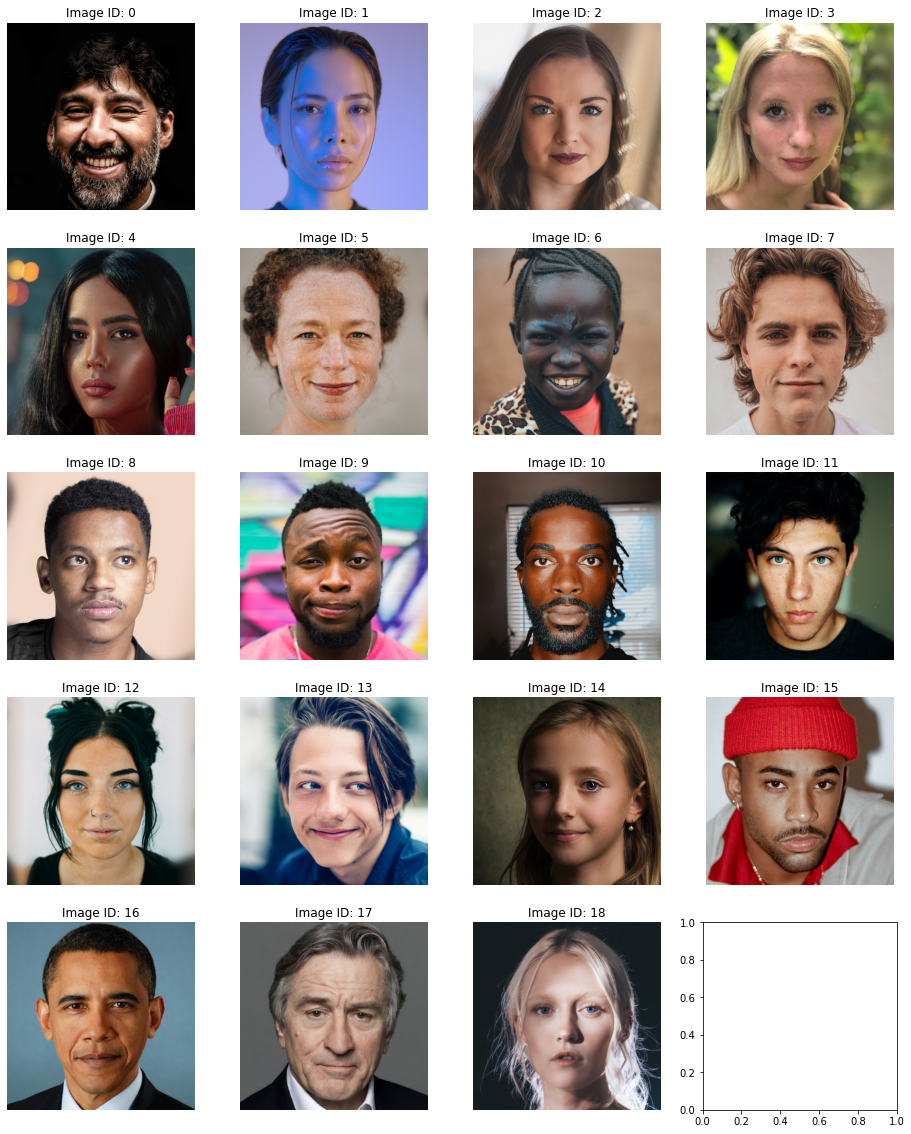

In [13]:
display_data(data)

# Preparing Relevant Functions

In [14]:
def get_PCA_results(q = 512, save = False, load = False):

  file_name = os.path.join(PCA_DIR,f"pca_results_q_{q}.npz")

  # Apply PCA
  if load:
    print("Loading: ", file_name)
    data = np.load(file_name)
    C = torch.tensor(data['eigen_vectors']).to(DEVICE)
    E = torch.tensor(data['eigen_values']).to(DEVICE)
    mean = torch.tensor(data['mean']).to(DEVICE)
    S = torch.tensor(data['singulars']).to(DEVICE)

  else:
    # q are the used principal component
    X = p_space.generate_samples(1e6, G, DEVICE)
    C, E, mean, S = p_space.apply_PCA(X, q = q)

  if save:
    print("Saving: ", file_name)
    np.savez(file_name, eigen_vectors =C.cpu().numpy(), 
                        eigen_values =E.cpu().numpy(),
                        mean = mean.cpu().numpy(),
                        singulars = S.cpu().numpy())

  return C, E, mean, S

In [15]:
C, E, mean, S = get_PCA_results(load=True)

Loading:  stuff/data/pca/pca_results_q_512.npz


In [17]:
# Defining relevant components to the loss function

# Pixel-Wise MSE Loss
MSE_Loss = nn.MSELoss(reduction="mean")

# Load LPIPS VGG16 feature detector. # StyleGANv2 version of metric
# url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
# with dnnlib.util.open_url(url) as f:
#     perceptual_vgg16 = torch.jit.load(f).eval().to(DEVICE)

# Load VGG16 feature detector. # StyleGANv2 version of metric
perceptual_vgg16 = lpips.LPIPS(net='vgg',version = '0.0').to(DEVICE)

# affine transformation to P_N+
affine_PN = p_space.mapping_P_N(C, S, mean)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.0], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.0/vgg.pth


In [18]:
#defining function to calculate loss
def calculate_loss(synth_img, reference_img, w_opt, perceptual_net, MSE_Loss, affine_PN, condition_function = None, downsampling_mode = 'bicubic', lambda_v = 0.001):
  
  # get the synth img to [0, 1] to measure the perceptual loss
  synth_img = (synth_img + 1) / 2
  # synth_img = (synth_img-torch.min(synth_img))/(torch.max(synth_img)-torch.min(synth_img))

  # transfor according to condition function
  if condition_function is not None:
    synth_img = condition_function(synth_img)

  # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
  tmp_synth_img = F.interpolate(synth_img, size=(256, 256), mode=downsampling_mode)
  tmp_reference_img = F.interpolate(reference_img, size=(256, 256), mode=downsampling_mode)

  transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
  ])

  # Normalize to [-1,1]
  # tmp_synth_img = 2*tmp_synth_img - 1
  # tmp_reference_img = 2*tmp_reference_img - 1
  tmp_synth_img = transform(tmp_synth_img)
  tmp_reference_img = transform(tmp_reference_img)

  # calculate LPIPS Perceptual Loss
  # Features for synth images.
  perceptual_loss = perceptual_net.forward(tmp_reference_img, tmp_synth_img)

  # normalize to [0,1] to measure the MSE loss
  # synth_img = synth_img / 255.0

  # normalize to [-1,1]
  synth_img = 2*synth_img - 1
  reference_img = 2*reference_img - 1
  # synth_img = transform(synth_img)
  # reference_img = transform(reference_img)

  # calculate MSE Loss
  mse_loss = MSE_Loss(synth_img,reference_img) 

  # adding the regulizer part
  regularizer = lambda_v * (torch.linalg.norm(affine_PN(w_opt)) ** 2)

  return mse_loss, perceptual_loss, regularizer

In [19]:
#@title Calculate mean latent to initialize
# 
n_samples = 5e5
def get_mean_latent():
  z = torch.randn((int(n_samples), 512), device=DEVICE)
  batch_size = int(1e5)

  w_mean = torch.zeros((1,18,512),requires_grad=True,device=DEVICE)
  for i in range(int(n_samples/batch_size)):
    w = G.mapping(z[i*batch_size:(i+1)*batch_size,:], None)
    w = torch.sum(w, dim = 0).unsqueeze(0)
    w_mean = w_mean + w

  w_mean = w_mean / n_samples

  return w_mean.clone().detach().requires_grad_(True)

In [20]:
def run_optimization(data, id, init, condition_function = None, sub_fix ="", downsampling_mode = 'bicubic', save_loss = False, lambda_v = 0.001):

  # get the image sample
  basename = data[id]['name'].split(".")[0] + sub_fix
  img = torch.tensor(data[id]['img'].copy(), device = DEVICE, dtype = torch.float32)
  img = img.permute(2, 0, 1).unsqueeze(0)

  img = img / 255.0
  
  # convert according to confition_function
  if condition_function is not None:
    img = condition_function(img)

  # extract the feature of the reference image
  # tmp_img = F.interpolate(img, size=(256, 256), mode=downsampling_mode)
  # target_features = perceptual_vgg16(tmp_img, resize_images=False, return_lpips=True)

  # normalize the image to [0,1] to measure MSE loss
  # img = img / 255.0
  
  ## convert according to confition_function
  #if condition_function is not None:
    #img = condition_function(img)


  # define the init latent
  if init == "w_mean":
    w_opt = get_mean_latent()
  elif init == "w_zeros":
    w_opt = torch.zeros((1,18,512),requires_grad=True,device=DEVICE)
  elif init == "w_random":
    w_opt = torch.cuda.FloatTensor(1,18,512).uniform_(-1,1).requires_grad_()


  optimizer = optim.Adam({w_opt},lr=LEARNING_RATE,betas=(BETA_1,BETA_2),eps=EPSILON)

  print("Starting Embedding: id: {} name: {}".format(id,basename))
  loss_list=[]
  loss_mse=[]
  loss_perceptual=[]
  latent_list = {}
  for i in range(0,ITERATIONS):
      # reset the gradients
      optimizer.zero_grad()

      # get the synthetic image
      synth_img = G.synthesis(w_opt, noise_mode='const')
      
      # get the loss and backpropagate the gradients
      mse_loss, perceptual_loss, regularizer_term = calculate_loss(synth_img,
                                                img,
                                                # target_features,
                                                w_opt,
                                                perceptual_vgg16, 
                                                MSE_Loss, 
                                                affine_PN,
                                                condition_function,
                                                downsampling_mode,
                                                lambda_v)
      loss = mse_loss + perceptual_loss + regularizer_term
      loss.backward()

      optimizer.step()

      # store the losses metrics
      loss_list.append(loss.item())
      loss_mse.append(mse_loss.item())
      loss_perceptual.append(perceptual_loss.item())

      # every SAVE_STEP, I store the current latent
      if (i +1) % SAVE_STEP == 0:
          print('iter[%d]:\t loss: %.4f\t mse_loss: %.4f\tpercep_loss: %.4f\tregularizer: %.4f' % (i+1,  
                                                                                                   loss.item(), 
                                                                                                   mse_loss.item(), 
                                                                                                   perceptual_loss.item(),
                                                                                                   regularizer_term.item()))
          latent_list[str(i+1)] = w_opt.detach().cpu().numpy()

  # store all the embeddings create during optimization in .npz
  path_embedding_latent = os.path.join(SAVING_DIR, 
                                      "latents/{}_latents_iters_{}_step_{}_{}.npz".format(
                                        basename,
                                        str(ITERATIONS).zfill(6),
                                        str(SAVE_STEP).zfill(4), 
                                        init))
  print("Saving: {}".format(path_embedding_latent))
  np.savez(path_embedding_latent, **latent_list)

  if save_loss:
    loss_file = "loss_plots/{}_loss_iters_{}_step_{}_{}.npy".format(
                                        basename,
                                        str(ITERATIONS).zfill(6),
                                        str(SAVE_STEP).zfill(4), 
                                        init)
    path_loss = os.path.join(SAVING_DIR, loss_file)
    print("Saving Loss: {}".format(path_loss))
    np.save(path_loss, np.array(loss_list))
  return loss_list

## Image colorization

* input image $I$: is a grayscale image
* condition function $f$: converts a color image to grayscale

Note: for the condition function, I used the following convertion of opencv [to_gray_scale](https://docs.opencv.org/3.1.0/de/d25/imgproc_color_conversions.html)

In [21]:
def convert2grayscale(image):
  result = 0.2989 * image[:,0,:,:] + 0.5870 * image[:,1,:,:] + 0.1140 * image[:,2,:,:]
  #result = (image[:,0,:,:] + image[:,1,:,:] + image[:,2,:,:]) / 3
  return torch.stack([result,result,result], dim=1)

torch.Size([1, 3, 1024, 1024])


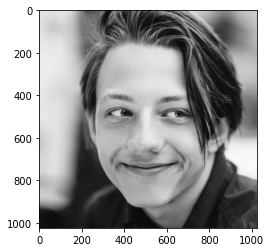

In [22]:
input_image = torch.tensor(data[13]['img'].copy(), device = DEVICE, dtype = torch.float32)
input_image = input_image/255.0
input_image = input_image.permute(2, 0, 1).unsqueeze(0)
result_img = convert2grayscale(input_image)
print(result_img.size())
plt.imshow(transforms.ToPILImage()(result_img.squeeze(0)))

In [23]:
test_name = '2gray'
mode = 'area'
lambda_v = 0.005

losses_opt = run_optimization(data, id = 13, init= 'w_mean', condition_function=convert2grayscale,
                 sub_fix=f"_{test_name}_{mode}_lambda_{lambda_v}",
                 save_loss = True, 
                 downsampling_mode=mode, 
                 lambda_v=lambda_v)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Starting Embedding: id: 13 name: janko-ferlic-GWFffQS5eWU-unsplash_2gray_area_lambda_0.005
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
iter[100]:	 loss: 0.1275	 mse_loss: 0.0504	percep_loss: 0.0753	regularizer: 0.0017
iter[200]:	 loss: 0.0942	 mse_loss: 0.0361	percep_loss: 0.0566	regularizer: 0.0015
iter[300]:	 loss: 0.0758	 mse_loss: 0.0284	percep_loss: 0.0459	regularizer: 0.0015
iter[400]:	 loss: 0.0677	 mse_loss: 0.0251	percep_loss: 0.0411	regularizer: 0.0015
iter[500]:	 loss: 0.0619	 mse_loss: 0.0227	percep_loss: 0.0378	regularizer: 0.0014
iter[600]:	 loss: 0.0576	 mse_loss: 0.0214	percep_loss: 0.0347	regularizer: 0.0014
iter[700]:	 loss: 0.0547	 mse_loss: 0.0203	percep_loss: 0.0328	regularizer: 0.0016
iter[800]:	 loss: 0.0516	 mse_loss: 0.0192	percep_loss: 0.0309	regularizer: 0.0015
iter[900]:	 loss: 0.0500	 mse_loss: 0.0185	percep_loss: 0.0299	regularizer: 0.0016
iter[1000]:	 loss: 0.0477	 mse_loss: 0.0177	percep_loss

In [ ]:
# testing downsampling
test_name = '2gray'
options_downsampling = ['area', 'bicubic', 'bilinear']
options_lambdas = [0.001, 0.005]

for mode in options_downsampling:
  for lambda_v in options_lambdas:
    loss_list = run_optimization(data, id = 13, init = 'w_mean', condition_function = convert2grayscale, sub_fix=f"_{test_name}_{mode}_lambda_{lambda_v}",save_loss = True, downsampling_mode=mode, lambda_v=lambda_v)

Starting Embedding: id: 13 name: janko-ferlic-GWFffQS5eWU-unsplash_2gray_area_lambda_0.001
iter[100]:	 loss: 0.1067	 mse_loss: 0.0424	percep_loss: 0.0634	regularizer: 0.0008
iter[200]:	 loss: 0.0764	 mse_loss: 0.0289	percep_loss: 0.0467	regularizer: 0.0008
iter[300]:	 loss: 0.0646	 mse_loss: 0.0243	percep_loss: 0.0395	regularizer: 0.0009
iter[400]:	 loss: 0.0563	 mse_loss: 0.0213	percep_loss: 0.0342	regularizer: 0.0009
iter[500]:	 loss: 0.0511	 mse_loss: 0.0196	percep_loss: 0.0307	regularizer: 0.0009
iter[600]:	 loss: 0.0488	 mse_loss: 0.0188	percep_loss: 0.0291	regularizer: 0.0008
iter[700]:	 loss: 0.0464	 mse_loss: 0.0180	percep_loss: 0.0276	regularizer: 0.0008
iter[800]:	 loss: 0.0446	 mse_loss: 0.0174	percep_loss: 0.0264	regularizer: 0.0008
iter[900]:	 loss: 0.0434	 mse_loss: 0.0170	percep_loss: 0.0256	regularizer: 0.0008
iter[1000]:	 loss: 0.0428	 mse_loss: 0.0169	percep_loss: 0.0250	regularizer: 0.0009
iter[1100]:	 loss: 0.0419	 mse_loss: 0.0166	percep_loss: 0.0245	regularizer: 0

In [ ]:
# testing lambdas
test_name = '2gray'
best_mode = 'bicubic'
loss_list = run_optimization(data, id = 13, init = 'w_mean', condition_function = convert2grayscale, sub_fix=f"_{test_name}_{best_mode}_lambda_{options_lambdas[1]}",save_loss = True, downsampling_mode=best_mode, lambda_v = options_lambdas[1])

Starting Embedding: id: 13 name: janko-ferlic-GWFffQS5eWU-unsplash_2gray_bicubic_lambda_0.005
iter[100]:	 loss: 0.3019	 mse_loss: 0.0184	percep_loss: 0.2808	regularizer: 0.0027
iter[200]:	 loss: 0.2407	 mse_loss: 0.0132	percep_loss: 0.2248	regularizer: 0.0027
iter[300]:	 loss: 0.2128	 mse_loss: 0.0113	percep_loss: 0.1989	regularizer: 0.0025
iter[400]:	 loss: 0.1953	 mse_loss: 0.0095	percep_loss: 0.1830	regularizer: 0.0027
iter[500]:	 loss: 0.1821	 mse_loss: 0.0086	percep_loss: 0.1704	regularizer: 0.0031
iter[600]:	 loss: 0.1719	 mse_loss: 0.0076	percep_loss: 0.1608	regularizer: 0.0035
iter[700]:	 loss: 0.1883	 mse_loss: 0.0078	percep_loss: 0.1758	regularizer: 0.0047
iter[800]:	 loss: 0.1533	 mse_loss: 0.0068	percep_loss: 0.1422	regularizer: 0.0044
iter[900]:	 loss: 0.1527	 mse_loss: 0.0065	percep_loss: 0.1414	regularizer: 0.0048
iter[1000]:	 loss: 0.1794	 mse_loss: 0.0069	percep_loss: 0.1660	regularizer: 0.0065
iter[1100]:	 loss: 0.1550	 mse_loss: 0.0060	percep_loss: 0.1426	regularizer

In [ ]:
# testing lambdas
test_name = '2gray'
best_mode = 'bilinear'
loss_list = run_optimization(data, id = 13, init = 'w_mean', condition_function = convert2grayscale, sub_fix=f"_{test_name}_{best_mode}_lambda_{options_lambdas[1]}",save_loss = True, downsampling_mode=best_mode, lambda_v = options_lambdas[1])

Starting Embedding: id: 13 name: janko-ferlic-GWFffQS5eWU-unsplash_2gray_bilinear_lambda_0.005
iter[100]:	 loss: 0.2813	 mse_loss: 0.0156	percep_loss: 0.2635	regularizer: 0.0022
iter[200]:	 loss: 0.2252	 mse_loss: 0.0116	percep_loss: 0.2114	regularizer: 0.0021
iter[300]:	 loss: 0.2018	 mse_loss: 0.0096	percep_loss: 0.1898	regularizer: 0.0024
iter[400]:	 loss: 0.1821	 mse_loss: 0.0083	percep_loss: 0.1711	regularizer: 0.0027
iter[500]:	 loss: 0.1703	 mse_loss: 0.0076	percep_loss: 0.1598	regularizer: 0.0029
iter[600]:	 loss: 0.1605	 mse_loss: 0.0070	percep_loss: 0.1506	regularizer: 0.0029
iter[700]:	 loss: 0.1546	 mse_loss: 0.0067	percep_loss: 0.1445	regularizer: 0.0034
iter[800]:	 loss: 0.1751	 mse_loss: 0.0066	percep_loss: 0.1622	regularizer: 0.0062
iter[900]:	 loss: 0.1887	 mse_loss: 0.0062	percep_loss: 0.1769	regularizer: 0.0056
iter[1000]:	 loss: 0.1550	 mse_loss: 0.0054	percep_loss: 0.1439	regularizer: 0.0057
iter[1100]:	 loss: 0.1516	 mse_loss: 0.0055	percep_loss: 0.1397	regularize

In [26]:
#@title Function to load latents
# Function to load the latents from the saved .npz file
def load_latents(file_name, display_latents = False):
  latent_embeddings_saved = os.path.join(SAVING_DIR, "latents/"+file_name)

  dictionary = {}
  with open(latent_embeddings_saved, 'rb') as f:
      container = np.load(f)
      
      for iter, latent in container.items():
          dictionary[iter] = latent
          if display_latents:
            print("iter: {} -- latent_code shape: {}".format(iter,latent.shape))
            print(latent[0,0,-5:])
  return dictionary

In [27]:
#@title Function to plot loss

# Function to plot the loss per iteration
def plot_loss(losses, basename,  save = False):

  plt.figure()
  scale_factor = 5

  plt.title("Loss During Embedding")
  for label, loss_file in losses.items():
    loss = np.load(os.path.join(SAVING_DIR, "loss_plots/" + loss_file))
    plt.plot(loss,label=label)
  plt.xlabel("Optimization Steps")
  plt.ylabel("Loss")
  plt.legend()
  

  if save:
    file_dir = os.path.join(SAVING_DIR, "loss_plots/{}_losses_iters_{}.svg".format(basename, str(ITERATIONS).zfill(6)))
    print("Saving: {}".format(file_dir))
    plt.savefig(file_dir)
    
  plt.show()

In [28]:
#@title Function to plot the synthetic image per iterations

def show_images_results(data, id, latents_file, iterations_to_show, generator, conditional_function = None, subfix = "", expected_result = False, save = False, save_last = False):

    latent_codes = load_latents(latents_file)
    base_names_list = latents_file.split(".")
    base_name = '.'.join(base_names_list[:-1])

    saved_iterations = list(latent_codes.keys())
    iterations_to_show_filter = [iter for iter in iterations_to_show if str(iter) in saved_iterations]

    n_images = len(iterations_to_show_filter) + 1
    inches = 4
    if expected_result: n_images += 1
    if conditional_function is not None: n_images += 1

    fig, axs = plt.subplots(1,n_images ,figsize=(inches * n_images , inches))

    # original image
    axs[0].imshow(data[id]['img'])
    axs[0].set_title('Original')
    axs[0].axis('off')

    # expected result
    if conditional_function is not None:
      input_image = torch.tensor(data[id]['img'].copy(), device = DEVICE, dtype = torch.float32)
      input_image = input_image.permute(2, 0, 1).unsqueeze(0)
      result_img = conditional_function(input_image)
      axs[1].imshow(transforms.ToPILImage()(result_img.squeeze(0)/255.0))
      axs[1].set_title('Conditional Image')
      axs[1].axis('off')

    # embeddings per iterations
    idx = 1 if conditional_function is None else 2
    for iter in iterations_to_show:
      latent = latent_codes.get(str(iter))

      if latent is not None:
        tensor_latent = torch.tensor(latent).to(DEVICE)
        synth_img = generator.synthesis(tensor_latent, noise_mode='const')
        synth_img = (synth_img + 1.0) / 2.0
        #(synth_img-torch.min(synth_img))/(torch.max(synth_img)-torch.min(synth_img))

        if save_last and iter == iterations_to_show[-1]:
          print("Saving last image...")
          save_image(synth_img.clamp(0,1), os.path.join(SAVING_DIR,"images/last_generated/{}.png".format(base_name)))

        synth_img = synth_img.detach().to('cpu').squeeze(0).permute(1, 2, 0)       
        axs[idx].imshow(synth_img.clamp(0,1))
        axs[idx].set_title("Iteration: {}".format(str(iter)))
        axs[idx].axis('off')



        idx += 1
      else:
        print("Iteration {} is not stored in file".format(iter))

    # expected result
    if expected_result:
      with open(EXPECTED_RESULTS + data[id]['name'],"rb") as f:
          image=Image.open(f)
          axs[idx].imshow(image)
          axs[idx].set_title('Expected Result')
          axs[idx].axis('off')

    if save:
      file_dir = os.path.join(SAVING_DIR, "images/{}{}.svg".format(
          base_name,
          subfix))
      print("Saving: {}".format(file_dir))
      plt.savefig(file_dir)

            

In [ ]:
losses_files = sorted(os.listdir(os.path.join(SAVING_DIR,"loss_plots")))
losses_files = { idx: loss_name for idx, loss_name in enumerate(losses_files) if ".npy" in loss_name }
losses_files

{0: 'erik-lucatero-d2MSDujJl2g-unsplash_inpainting_loss_iters_001300_step_0100_w_mean.npy',
 1: 'hassan-khan-EGVccebWodM-unsplash_2gray_loss_iters_001300_step_0100_w_mean.npy',
 2: 'hassan-khan-EGVccebWodM-unsplash_inpainting_area_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy',
 3: 'hassan-khan-EGVccebWodM-unsplash_inpainting_area_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy',
 4: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bicubic_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy',
 5: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bicubic_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy',
 6: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bicubic_loss_iters_001300_step_0100_w_mean.npy',
 7: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bilinear_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy',
 8: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bilinear_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy',
 9: 'hassan-khan-EGVccebWodM-unsplash_inpainting_loss_iters_001

In [ ]:
losses = { "loss lr=0.01 lambda=0.001 downsampling_mode=area" : losses_files[10],
          "loss lr=0.01 lambda=0.005 downsampling_mode=area" : losses_files[11],
          "loss lr=0.01 lambda=0.001 downsampling_mode=bicubic" : losses_files[12],
          "loss lr=0.01 lambda=0.005 downsampling_mode=bicubic" : losses_files[13],
          "loss lr=0.01 lambda=0.001 downsampling_mode=bilinear" : losses_files[15],
          "loss lr=0.01 lambda=0.005 downsampling_mode=bilinear" : losses_files[16]
          }

Saving: stuff/results/conditional_embedding/loss_plots/losses_per_test_losses_iters_001300.svg


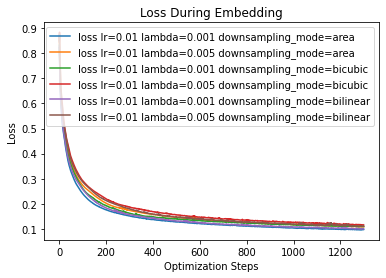

In [ ]:
# plot losses
plot_loss(losses, basename = "losses_per_test",save = True)

In [24]:
latents_files = sorted(os.listdir(SAVING_DIR + "/latents"))
latents_files = {idx : f for idx, f in enumerate(latents_files) if ".npz" in f}
latents_files

{0: 'erik-lucatero-d2MSDujJl2g-unsplash_inpainting_latents_iters_001300_step_0100_w_mean.npz',
 1: 'hassan-khan-EGVccebWodM-unsplash_2gray_latents_iters_001300_step_0100_w_mean.npz',
 2: 'hassan-khan-EGVccebWodM-unsplash_inpainting_area_lambda_0.001_latents_iters_001300_step_0100_w_mean.npz',
 3: 'hassan-khan-EGVccebWodM-unsplash_inpainting_area_lambda_0.005_latents_iters_001300_step_0100_w_mean.npz',
 4: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bicubic_lambda_0.001_latents_iters_001300_step_0100_w_mean.npz',
 5: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bicubic_lambda_0.005_latents_iters_001300_step_0100_w_mean.npz',
 6: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bilinear_lambda_0.001_latents_iters_001300_step_0100_w_mean.npz',
 7: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bilinear_lambda_0.005_latents_iters_001300_step_0100_w_mean.npz',
 8: 'hassan-khan-EGVccebWodM-unsplash_inpainting_latents_iters_001300_step_0100_w_mean.npz',
 9: 'janko-ferlic-GWFffQS5eWU-unsplash_2gray

Saving last image...
Saving: stuff/results/conditional_embedding/images/janko-ferlic-GWFffQS5eWU-unsplash_2gray_area_lambda_0.005_latents_iters_001300_step_0100_w_mean.svg


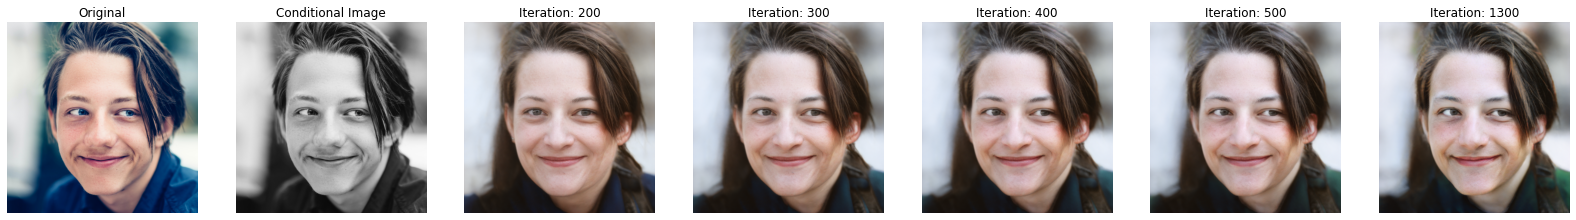

In [30]:
show_images_results(data, 13, latents_files[10], [200,300,400,500,1300], G, convert2grayscale, expected_result=False, save=True, save_last=True)

Saving last image...
Saving: stuff/results/conditional_embedding/images/janko-ferlic-GWFffQS5eWU-unsplash_2gray_area_lambda_0.005_latents_iters_001300_step_0100_w_mean.svg


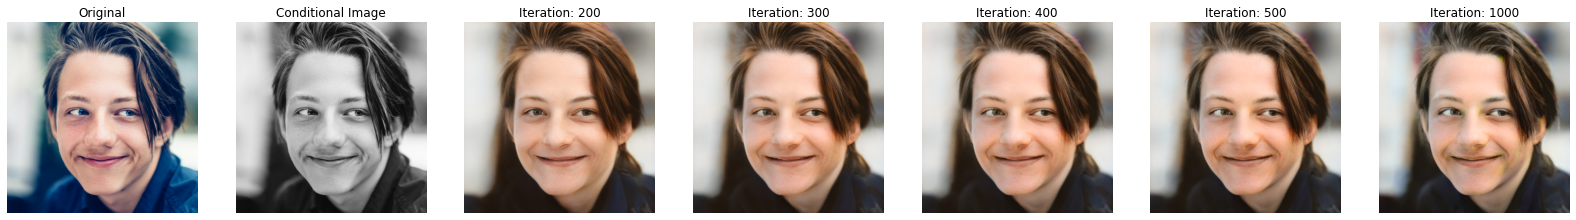

In [ ]:
show_images_results(data, 13, latents_files[10], [200,300,400,500,1000], G, convert2grayscale, expected_result=False, save=True, save_last=True)

In [ ]:
for i in np.arange(9,15):
  print("latenst: ", latents_files[i])
  show_images_results(data, 13, latents_files[i], [300,400,500,1300], G, convert2grayscale, expected_result=False, save=True, save_last=True)

Output hidden; open in https://colab.research.google.com to view.

Saving last image...
Saving: stuff/results/conditional_embedding/images/janko-ferlic-GWFffQS5eWU-unsplash_2gray_bilinear_lambda_0.svg


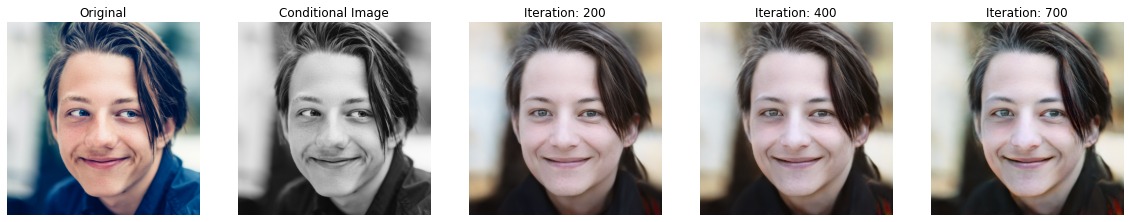

In [ ]:
show_images_results(data, 13, latents_files[14], [200,400,700], G, convert2grayscale, expected_result=False, save=True, save_last=True)

## Image Inpainting

* input image $I$: incomplete image
* condition function $f$: is a *mask* function that erases the pixels in a given region.

Note: in authors' tests the missing refion is half the image.


In [ ]:
def mask_function(image):
  n, c, h, w = image.size()  
  image[:,:,:,-int(w/2):] = 0.
  return image

In [ ]:
input_image = torch.tensor(data[12]['img'].copy(), device = DEVICE, dtype = torch.float32)
input_image = input_image.permute(2, 0, 1).unsqueeze(0)
result_img = mask_function(input_image)
print(result_img.size())
plt.imshow(transforms.ToPILImage()(result_img.squeeze(0)/255.0))

In [ ]:
# testing downsampling
test_name = 'inpainting'
options_downsampling = ['area', 'bicubic', 'bilinear']
options_lambdas = [0.001, 0.005]

for mode in options_downsampling:
  for lambda_v in options_lambdas:
    loss_list = run_optimization(data, id = 12, init = 'w_mean', condition_function = mask_function, sub_fix=f"_{test_name}_{mode}_lambda_{lambda_v}",save_loss = True, downsampling_mode=mode, lambda_v=lambda_v)

In [ ]:
losses_files = sorted(os.listdir(os.path.join(SAVING_DIR,"loss_plots")))
losses_files = { idx: loss_name for idx, loss_name in enumerate(losses_files) if ".npy" in loss_name }
losses_files

{0: 'erik-lucatero-d2MSDujJl2g-unsplash_inpainting_loss_iters_001300_step_0100_w_mean.npy',
 1: 'hassan-khan-EGVccebWodM-unsplash_2gray_loss_iters_001300_step_0100_w_mean.npy',
 2: 'hassan-khan-EGVccebWodM-unsplash_inpainting_area_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy',
 3: 'hassan-khan-EGVccebWodM-unsplash_inpainting_area_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy',
 4: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bicubic_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy',
 5: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bicubic_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy',
 6: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bicubic_loss_iters_001300_step_0100_w_mean.npy',
 7: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bilinear_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy',
 8: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bilinear_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy',
 9: 'hassan-khan-EGVccebWodM-unsplash_inpainting_loss_iters_001

In [ ]:
losses = { "loss lr=0.01 lambda=0.001 downsampling_mode=area" : losses_files[2],
          "loss lr=0.01 lambda=0.005 downsampling_mode=area" : losses_files[3],
          "loss lr=0.01 lambda=0.001 downsampling_mode=bicubic" : losses_files[4],
          "loss lr=0.01 lambda=0.005 downsampling_mode=bicubic" : losses_files[5],
          "loss lr=0.01 lambda=0.001 downsampling_mode=bilinear" : losses_files[7],
          "loss lr=0.01 lambda=0.005 downsampling_mode=bilinear" : losses_files[8]
          }

Saving: stuff/results/conditional_embedding/loss_plots/losses_per_test_losses_iters_001300.svg


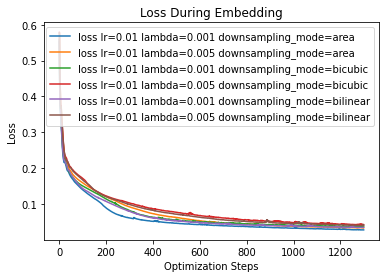

In [ ]:
# plot losses
plot_loss(losses, basename = "losses_per_test",save = True)

In [ ]:
latents_files = sorted(os.listdir(SAVING_DIR + "/latents"))
latents_files = [f for f in latents_files if ".npz" in f]
latents_files

['erik-lucatero-d2MSDujJl2g-unsplash_inpainting_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_2gray_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_inpainting_area_lambda_0.001_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_inpainting_area_lambda_0.005_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_inpainting_bicubic_lambda_0.001_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_inpainting_bicubic_lambda_0.005_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_inpainting_bilinear_lambda_0.001_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_inpainting_bilinear_lambda_0.005_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_inpainting_latents_iters_001300_step_0100_w_mean.npz',
 'janko-ferlic-GWFffQS5eWU-unsplash_2gray_area_lambda_0.001_latents_ite

In [ ]:
for i in np.arange(2,8):
  print("latenst: ", latents_files[i])
  show_images_results(data, 12, latents_files[i], [300,400,500,700], G, mask_function, expected_result=False, save=True, save_last=True)

Output hidden; open in https://colab.research.google.com to view.

Saving last image...
Saving: stuff/results/conditional_embedding/images/hassan-khan-EGVccebWodM-unsplash_inpainting_area_lambda_0.svg


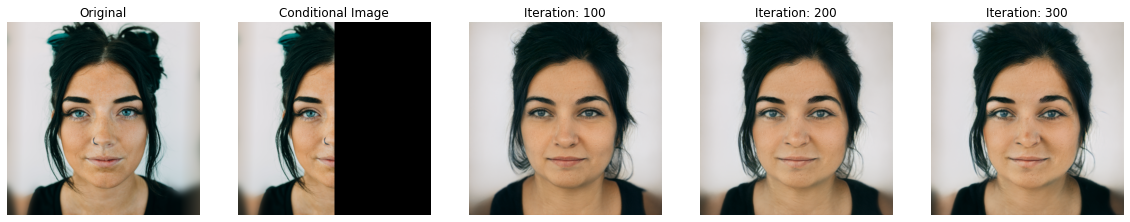

In [ ]:
show_images_results(data, 12, latents_files[2], [100,200,300], G, mask_function, expected_result=False, save=True, save_last=True)

## Super Resolution

* input image $I$: $32\times 32$ low-resolution image.
* condition function $f$ is a downsampling function

In [ ]:
def downsampling_function(image):
  return F.interpolate(image, size=(32, 32), mode='area')

In [ ]:
input_image = torch.tensor(data[14]['img'].copy(), device = DEVICE, dtype = torch.float32)
input_image = input_image.permute(2, 0, 1).unsqueeze(0)
result_img = downsampling_function(input_image)
print(result_img.size())
plt.imshow(transforms.ToPILImage()(result_img.squeeze(0)/255.0))

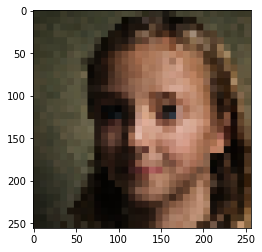

In [ ]:
tmpo = F.interpolate(result_img, size=(256, 256), mode='bicubic').clamp(0,255.0)
plt.imshow(transforms.ToPILImage()(tmpo.squeeze(0)/255.0))

In [ ]:
# testing downsampling
test_name = 'super_resolution'
options_downsampling = ['area', 'bicubic', 'bilinear']
options_lambdas = [0.001, 0.005]

for mode in options_downsampling:
  for lambda_v in options_lambdas:
    loss_list = run_optimization(data, id = 14, init = 'w_mean', condition_function = downsampling_function, sub_fix=f"_{test_name}_{mode}_lambda_{lambda_v}",save_loss = True, downsampling_mode=mode, lambda_v=lambda_v)

In [ ]:
losses_files = sorted(os.listdir(os.path.join(SAVING_DIR,"loss_plots")))
losses_files = { idx: loss_name for idx, loss_name in enumerate(losses_files) if ".npy" in loss_name }
losses_files

{0: 'erik-lucatero-d2MSDujJl2g-unsplash_inpainting_loss_iters_001300_step_0100_w_mean.npy',
 1: 'hassan-khan-EGVccebWodM-unsplash_2gray_loss_iters_001300_step_0100_w_mean.npy',
 2: 'hassan-khan-EGVccebWodM-unsplash_inpainting_area_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy',
 3: 'hassan-khan-EGVccebWodM-unsplash_inpainting_area_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy',
 4: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bicubic_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy',
 5: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bicubic_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy',
 6: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bicubic_loss_iters_001300_step_0100_w_mean.npy',
 7: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bilinear_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy',
 8: 'hassan-khan-EGVccebWodM-unsplash_inpainting_bilinear_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy',
 9: 'hassan-khan-EGVccebWodM-unsplash_inpainting_loss_iters_001

In [ ]:
losses = { "loss lr=0.01 lamda=0.001 downsampling_mode=area" : losses_files[19],
          "loss lr=0.01 lamda=0.005 downsampling_mode=area" : losses_files[20],
          "loss lr=0.01 lamda=0.001 downsampling_mode=bicubic" : losses_files[21],
          "loss lr=0.01 lamda=0.005 downsampling_mode=bicubic" : losses_files[22],
          "loss lr=0.01 lamda=0.001 downsampling_mode=bilinear" : losses_files[23],
          "loss lr=0.01 lamda=0.005 downsampling_mode=bilinear" : losses_files[24]
          }

Saving: stuff/results/conditional_embedding/loss_plots/losses_per_test_losses_iters_001300.svg


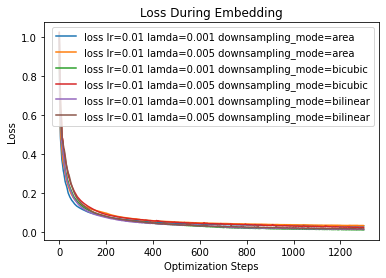

In [ ]:
# plot losses
plot_loss(losses, basename = "losses_per_test",save = True)

In [ ]:
latents_files = sorted(os.listdir(SAVING_DIR + "/latents"))
latents_files = [f for f in latents_files if ".npz" in f]
latents_files

['erik-lucatero-d2MSDujJl2g-unsplash_inpainting_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_2gray_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_inpainting_area_lambda_0.001_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_inpainting_area_lambda_0.005_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_inpainting_bicubic_lambda_0.001_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_inpainting_bicubic_lambda_0.005_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_inpainting_bilinear_lambda_0.001_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_inpainting_bilinear_lambda_0.005_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_inpainting_latents_iters_001300_step_0100_w_mean.npz',
 'janko-ferlic-GWFffQS5eWU-unsplash_2gray_area_lambda_0.001_latents_ite

In [ ]:
for i in np.arange(18,24):
  print("latenst: ", latents_files[i])
  show_images_results(data, 14, latents_files[i], [300,400,500,700,1300], G, downsampling_function, expected_result=False, save=True, save_last=True)

Output hidden; open in https://colab.research.google.com to view.

Saving last image...
Saving: stuff/results/conditional_embedding/images/janko-ferlic-XbxQbS1NMKE-unsplash_super_resolution_bilinear_lambda_0.svg


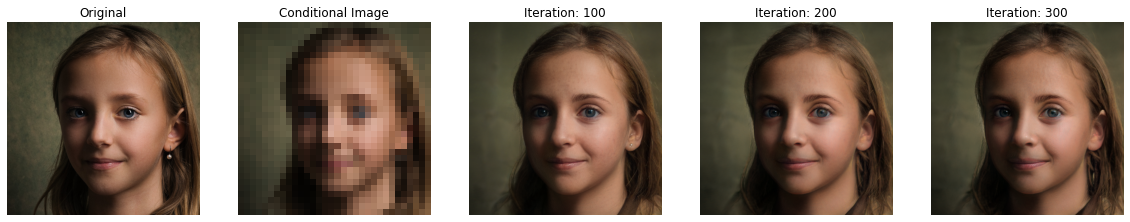

In [ ]:
show_images_results(data, 14, latents_files[-4], [100,200,300], G, downsampling_function, expected_result=False, save=True, save_last=True)

## Style Transfer

It was accomplished using a different approach. Let $G$ and $G'$ bet two StyleGAN generators, $G$ is trained on the FFHQ dataset and $G'$ is a variant of fine-tuned on the MetFace dataset.

Then, the **style transfer** is implemented by embedding the input image into $G$ and then evaluating the resulting latent code using $G'$.

In [ ]:
# testing downsampling
test_name = 'style_transfer'
options_downsampling = ['area', 'bicubic', 'bilinear']
options_lambdas = [0.001, 0.005]

for mode in options_downsampling:
  for lambda_v in options_lambdas:
    loss_list = run_optimization(data, id = 18, init = 'w_mean', 
                                 sub_fix=f"_{test_name}_{mode}_lambda_{lambda_v}",
                                 save_loss = True, 
                                 downsampling_mode=mode, 
                                 lambda_v=lambda_v)

In [ ]:
loss_list = run_optimization(data, id = 18, init = 'w_mean', sub_fix="_style_transfer",save_loss = True)

Starting Embedding: id: 18 name: vinicius-amnx-amano-o3c8SD-oJeM-unsplash_style_transfer
iter[100]:	 loss: 0.2515	 mse_loss: 0.0190	percep_loss: 0.2316	regularizer: 0.0009
iter[200]:	 loss: 0.2067	 mse_loss: 0.0127	percep_loss: 0.1929	regularizer: 0.0011
iter[300]:	 loss: 0.1835	 mse_loss: 0.0104	percep_loss: 0.1718	regularizer: 0.0013
iter[400]:	 loss: 0.1703	 mse_loss: 0.0092	percep_loss: 0.1597	regularizer: 0.0014
iter[500]:	 loss: 0.1592	 mse_loss: 0.0084	percep_loss: 0.1494	regularizer: 0.0014
iter[600]:	 loss: 0.1526	 mse_loss: 0.0079	percep_loss: 0.1432	regularizer: 0.0015
iter[700]:	 loss: 0.1471	 mse_loss: 0.0076	percep_loss: 0.1380	regularizer: 0.0015
iter[800]:	 loss: 0.1424	 mse_loss: 0.0072	percep_loss: 0.1337	regularizer: 0.0015
iter[900]:	 loss: 0.1394	 mse_loss: 0.0070	percep_loss: 0.1309	regularizer: 0.0015
iter[1000]:	 loss: 0.1347	 mse_loss: 0.0068	percep_loss: 0.1263	regularizer: 0.0015
iter[1100]:	 loss: 0.1337	 mse_loss: 0.0066	percep_loss: 0.1255	regularizer: 0.0

In [ ]:
latents_files = sorted(os.listdir(SAVING_DIR + "/latents"))
latents_files = [f for f in latents_files if ".npz" in f]
latents_files

['erik-lucatero-d2MSDujJl2g-unsplash_inpainting_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_2gray_latents_iters_001300_step_0100_w_mean.npz',
 'hassan-khan-EGVccebWodM-unsplash_inpainting_latents_iters_001300_step_0100_w_mean.npz',
 'janko-ferlic-GWFffQS5eWU-unsplash_2gray_latents_iters_001300_step_0100_w_mean.npz',
 'janko-ferlic-XbxQbS1NMKE-unsplash_super_resolution_latents_iters_001300_step_0100_w_mean.npz',
 'vinicius-amnx-amano-o3c8SD-oJeM-unsplash_style_transfer_latents_iters_001300_step_0100_w_mean.npz']

In [ ]:
generator2 = load_pretrained_model(file_name = "metfaces.pkl",space='w+')

Saving last image...
Saving: stuff/results/conditional_embedding/images/vinicius-amnx-amano-o3c8SD-oJeM-unsplash_style_transfer_latents_iters_001300_step_0100_w_mean.svg


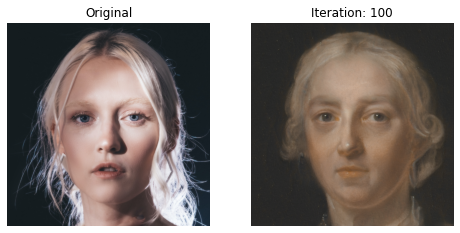

In [ ]:
show_images_results(data, 18, latents_files[3], [100], generator = generator2, save=True, save_last=True)